# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures']
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures']
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals']
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals']
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [5]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,15.0,8.0,8.0,8.0,8.0,8.0,22.0,22.0,8.0,22.0
DEP_DELAY,28.0,90.0,32.0,24.0,-1.0,0.0,-9.0,17.0,2.0,1.0,...,81.0,23.0,-1.0,-6.0,14.0,10.0,-5.0,0.0,35.0,0.0
TAXI_OUT,26.0,12.0,17.0,16.0,29.0,16.0,19.0,24.0,23.0,31.0,...,20.0,29.0,39.0,36.0,45.0,21.0,29.0,27.0,29.0,27.0
TAXI_IN,3.0,5.0,4.0,6.0,4.0,6.0,5.0,3.0,3.0,7.0,...,5.0,6.0,5.0,5.0,8.0,11.0,11.0,7.0,10.0,5.0
CRS_ARR_TIME,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,17.0,16.0,16.0,16.0,16.0,7.0,7.0,16.0,7.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
DIVERTED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [6]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [7]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [8]:
def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    return flight_edges_df, bn

def draw_graph(df):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.show()

### ARR_DEL15

In [9]:
arr_15_from = ['CRS_DEP_TIME','DEP_DELAY','CRS_ARR_TIME','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[arr_15_from]
y = train_df['ARR_DEL15']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     360.1
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          2.37e-219
Time:                        06:35:32   Log-Likelihood:                -335.27
No. Observations:                 774   AIC:                             682.5
Df Residuals:                     768   BIC:                             710.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0149      0.001     11.453      0.000       0.012       0.017
DEP_DELAY              -0.0029      0.001     -3.400      0.001      -0.005      -0.001
CRS_ARR_TIME            0.0079      0.001      5.688      0.000       0.005       0.011
CARRIER_DELAY           0.0104      0.001      9.471      0.000       0.008       0.013
NAS_DELAY               0.0137      0.001     17.660      0.000       0.012       0.015
LATE_AIRCRAFT_DELAY     0.0102      0.001      9.019      0.000       0.008       0.012
==============================================================================
Omnibus:                        4.461   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.294
Skew:                          -0.166   Prob(JB):                        0.117
Kurtosis:                       3.150   Cond. No.                         6.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

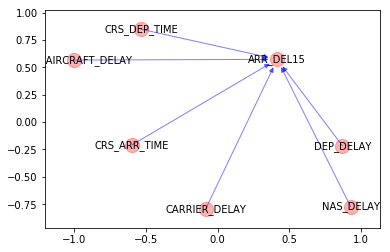

In [10]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df)

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [11]:
nas_delay_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','LATE_AIRCRAFT_DELAY',]

X = train_df[nas_delay_from]
y = train_df['NAS_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     137.8
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          1.43e-153
Time:                        06:35:33   Log-Likelihood:                -3064.8
No. Observations:                 774   AIC:                             6148.
Df Residuals:                     765   BIC:                             6189.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                -1.7207      0.417     -4.125      0.000      -2.540      -0.902
CRS_DEP_TIME           -0.6869      0.066    -10.345      0.000      -0.817      -0.557
DEP_DELAY               0.6107      0.030     20.376      0.000       0.552       0.669
TAXI_OUT                0.8680      0.041     21.045      0.000       0.787       0.949
TAXI_IN                 0.8168      0.058     14.035      0.000       0.703       0.931
CRS_ARR_TIME           -0.7823      0.075    -10.380      0.000      -0.930      -0.634
DIVERTED            -9.677e-16   1.56e-16     -6.208      0.000   -1.27e-15   -6.62e-16
CARRIER_DELAY          -0.6424      0.038    -17.073      0.000      -0.716      -0.569
WEATHER_DELAY          -0.5540      0.081     -6.799      0.000      -0.714      -0.394
LATE_AIRCRAFT_DELAY    -0.6515      0.039    -16.755      0.000      -0.728      -0.575
==============================================================================
Omnibus:                      164.629   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              458.805
Skew:                           1.062   Prob(JB):                    2.35e-100
Kurtosis:                       6.117   Cond. No.                     8.54e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

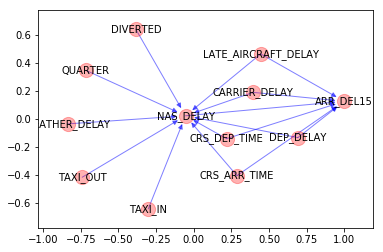

In [12]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)
draw_graph(flight_edges_df)

Now, we check to make sure there are no cycles. The find_cycle function in networkx will return a list of edges for an existing cycle.

In [13]:
try:
    nx.find_cycle(bn, source=None, orientation='original')
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [14]:
late_aircraft_from = ['MONTH','DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY']
X = train_df[late_aircraft_from]
y = train_df['LATE_AIRCRAFT_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.785
Model:                             OLS   Adj. R-squared:                  0.783
Method:                  Least Squares   F-statistic:                     561.0
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          1.11e-253
Time:                         06:35:33   Log-Likelihood:                -2964.9
No. Observations:                  774   AIC:                             5940.
Df Residuals:                      769   BIC:                             5963.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH             0.2845      0.060      4.753      0.000       0.167       0.402
DEP_DELAY         0.6656      0.013     50.038      0.000       0.640       0.692
CARRIER_DELAY    -0.7304      0.023    -31.784      0.000      -0.775      -0.685
WEATHER_DELAY    -0.6786      0.068    -10.001      0.000      -0.812      -0.545
NAS_DELAY        -0.2278      0.022    -10.442      0.000      -0.271      -0.185
==============================================================================
Omnibus:                      315.450   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14636.654
Skew:                          -1.074   Prob(JB):                         0.00
Kurtosis:                      24.195   Cond. No.                         8.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'NAS_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [16]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'LATE_AIRCRAFT_DELAY')]
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'LATE_AIRCRAFT_DELAY') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Carrier Delay

In [17]:
carrier_delay_from = ['CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[carrier_delay_from]
y = train_df['CARRIER_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     414.2
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          3.13e-272
Time:                        06:35:33   Log-Likelihood:                -2909.0
No. Observations:                 774   AIC:                             5834.
Df Residuals:                     766   BIC:                             5871.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME           -0.4412      0.053     -8.395      0.000      -0.544      -0.338
DEP_DELAY               0.7478      0.014     53.847      0.000       0.721       0.775
TAXI_OUT                0.4449      0.037     11.940      0.000       0.372       0.518
TAXI_IN                 0.4533      0.050      9.045      0.000       0.355       0.552
CRS_ARR_TIME           -0.5672      0.059     -9.561      0.000      -0.684      -0.451
DIVERTED            -4.109e-15   3.63e-16    -11.315      0.000   -4.82e-15    -3.4e-15
WEATHER_DELAY          -0.7179      0.063    -11.311      0.000      -0.842      -0.593
NAS_DELAY              -0.4286      0.025    -17.299      0.000      -0.477      -0.380
LATE_AIRCRAFT_DELAY    -0.8189      0.022    -36.649      0.000      -0.863      -0.775
==============================================================================
Omnibus:                      216.805   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3463.753
Skew:                          -0.811   Prob(JB):                         0.00
Kurtosis:                      13.236   Cond. No.                     1.79e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.59e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'NAS_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [19]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'CARRIER_DELAY')]
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'CARRIER_DELAY') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

In [20]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'CARRIER_DELAY') | (flight_edges_df.to_node != 'LATE_AIRCRAFT_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### WEATHER_DELAY

Though not ideal in p-value, CRS_DEP_TIME seems like the only likely variable which WEATHER_DELAY may be dependent on.

In [21]:
weather_delay_from = ['CRS_DEP_TIME']
X = train_df[weather_delay_from]
y = train_df['WEATHER_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.718
Date:                Thu, 29 Mar 2018   Prob (F-statistic):             0.0996
Time:                        06:35:33   Log-Likelihood:                -2488.9
No. Observations:                 774   AIC:                             4980.
Df Residuals:                     773   BIC:                             4984.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
CRS_DEP_TIME     0.0237      0.014      1.649      0.100      -0.005       0.052
==============================================================================
Omnibus:                     2020.922   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18215698.618
Skew:                          27.271   Prob(JB):                         0.00
Kurtosis:                     752.569   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Security Delay

Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

In [23]:
security_delay_from = ['DAY_OF_WEEK','DEP_DELAY','TAXI_OUT','CARRIER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[security_delay_from]
y = train_df['SECURITY_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SECURITY_DELAY   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.300
Date:                Thu, 29 Mar 2018   Prob (F-statistic):            0.00326
Time:                        06:35:33   Log-Likelihood:                -1643.6
No. Observations:                 774   AIC:                             3299.
Df Residuals:                     768   BIC:                             3327.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
DAY_OF_WEEK            -0.0634      0.030     -2.082      0.038      -0.123      -0.004
DEP_DELAY               0.0181      0.005      3.768      0.000       0.009       0.028
TAXI_OUT                0.0110      0.005      2.337      0.020       0.002       0.020
CARRIER_DELAY          -0.0200      0.006     -3.272      0.001      -0.032      -0.008
NAS_DELAY              -0.0108      0.005     -2.272      0.023      -0.020      -0.001
LATE_AIRCRAFT_DELAY    -0.0148      0.006     -2.327      0.020      -0.027      -0.002
==============================================================================
Omnibus:                     2006.206   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17411512.944
Skew:                          26.776   Prob(JB):                         0.00
Kurtosis:                     735.819   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(security_delay_from, 'SECURITY_DELAY',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [25]:
quarter_from = ['MONTH','CRS_DEP_TIME','CRS_ARR_TIME']
X = train_df[quarter_from]
y = train_df['QUARTER']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.706e+04
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:35:33   Log-Likelihood:                -107.99
No. Observations:                 774   AIC:                             222.0
Df Residuals:                     771   BIC:                             235.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3237      0.003    111.655      0.000       0.318       0.329
CRS_DEP_TIME     0.0116      0.001      9.767      0.000       0.009       0.014
CRS_ARR_TIME     0.0167      0.001     13.632      0.000       0.014       0.019
==============================================================================
Omnibus:                     1963.197   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.881
Skew:                           0.085   Prob(JB):                     4.45e-13
Kurtosis:                       1.683   Cond. No.                         6.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [27]:
departure_delay_from = ['QUARTER','MONTH','DAY_OF_WEEK','CRS_DEP_TIME','TAXI_OUT','TAXI_IN','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[departure_delay_from]
y = train_df['DEP_DELAY']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     792.0
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:35:33   Log-Likelihood:                -3023.5
No. Observations:                 774   AIC:                             6071.
Df Residuals:                     762   BIC:                             6127.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 5.9326      1.580      3.755      0.000       2.831       9.034
MONTH                  -1.9289      0.526     -3.669      0.000      -2.961      -0.897
DAY_OF_WEEK             0.5818      0.212      2.740      0.006       0.165       0.999
CRS_DEP_TIME            0.5660      0.067      8.423      0.000       0.434       0.698
TAXI_OUT               -0.6636      0.043    -15.389      0.000      -0.748      -0.579
TAXI_IN                -0.6060      0.058    -10.416      0.000      -0.720      -0.492
CRS_ARR_TIME            0.7459      0.077      9.714      0.000       0.595       0.897
DIVERTED             7.009e-15   1.79e-15      3.923      0.000     3.5e-15    1.05e-14
CARRIER_DELAY           1.0528      0.019     54.583      0.000       1.015       1.091
WEATHER_DELAY           0.9643      0.073     13.277      0.000       0.822       1.107
NAS_DELAY               0.5700      0.028     20.563      0.000       0.516       0.624
SECURITY_DELAY          0.8556      0.214      3.999      0.000       0.436       1.276
LATE_AIRCRAFT_DELAY     1.0862      0.020     55.032      0.000       1.047       1.125
==============================================================================
Omnibus:                      364.537   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5787.859
Skew:                           1.711   Prob(JB):                         0.00
Kurtosis:                      15.952   Cond. No.                     4.73e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.83e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


It is not very likely that an NAS-related delay causes a security-related delay. Therefore, we will remove the edge from NAS_DELAY to SECURITY_DELAY.

In [29]:
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'SECURITY_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [30]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'NAS_DELAY') | (flight_edges_df.to_node != 'DEP_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY')]


Departure delay cannot lead to a late aircraft delay: this is temporally impossible, so we get rid of that directed edge.

In [31]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DEP_DELAY') | (flight_edges_df.to_node != 'LATE_AIRCRAFT_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


Again, temporally, departure delay cannot lead to a carrier delay. Therefore, we remove that directed edge.

In [32]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DEP_DELAY') | (flight_edges_df.to_node != 'CARRIER_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'SECURITY_DELAY')]


By the same reasoning as above, we remove the edge from DEP_DELAY to SECURITY_DELAY.

In [33]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DEP_DELAY') | (flight_edges_df.to_node != 'SECURITY_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [34]:
taxi_out_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_IN','CRS_ARR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[taxi_out_from]
y = train_df['TAXI_OUT']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     850.9
Date:                Thu, 29 Mar 2018   Prob (F-statistic):               0.00
Time:                        06:35:33   Log-Likelihood:                -2784.2
No. Observations:                 774   AIC:                             5588.
Df Residuals:                     764   BIC:                             5635.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 2.3138      0.282      8.219      0.000       1.761       2.866
CRS_DEP_TIME            0.7820      0.041     19.281      0.000       0.702       0.862
DEP_DELAY              -0.3545      0.023    -15.526      0.000      -0.399      -0.310
TAXI_IN                -0.3765      0.043     -8.680      0.000      -0.462      -0.291
CRS_ARR_TIME            0.9288      0.045     20.673      0.000       0.841       1.017
CARRIER_DELAY           0.3319      0.029     11.585      0.000       0.276       0.388
WEATHER_DELAY           0.2684      0.058      4.650      0.000       0.155       0.382
NAS_DELAY               0.4250      0.020     21.163      0.000       0.386       0.464
SECURITY_DELAY          0.3045      0.158      1.932      0.054      -0.005       0.614
LATE_AIRCRAFT_DELAY     0.3362      0.029     11.437      0.000       0.279       0.394
==============================================================================
Omnibus:                       49.811   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.178
Skew:                           0.532   Prob(JB):                     9.51e-16
Kurtosis:                       4.006   Cond. No.                         45.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY')]


In [36]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_OUT') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [37]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_OUT') | (flight_edges_df.to_node != 'CARRIER_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [38]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_OUT') | (flight_edges_df.to_node != 'SECURITY_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'NAS_DELAY')]


In [39]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DEP_DELAY') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [40]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DEP_DELAY') | (flight_edges_df.to_node != 'TAXI_OUT')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### Taxi In

In [41]:
taxi_in_from = ['QUARTER','CRS_DEP_TIME','DEP_DELAY','TAXI_OUT','CRS_ARR_TIME','DIVERTED','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','LATE_AIRCRAFT_DELAY']
X = train_df[taxi_in_from]
y = train_df['TAXI_IN']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     132.6
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          1.26e-149
Time:                        06:35:34   Log-Likelihood:                -2607.6
No. Observations:                 774   AIC:                             5233.
Df Residuals:                     765   BIC:                             5275.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.9723      0.231      4.210      0.000       0.519       1.426
CRS_DEP_TIME            0.3256      0.037      8.691      0.000       0.252       0.399
DEP_DELAY              -0.1976      0.019    -10.216      0.000      -0.236      -0.160
TAXI_OUT               -0.2369      0.027     -8.643      0.000      -0.291      -0.183
CRS_ARR_TIME            0.4472      0.042     10.760      0.000       0.366       0.529
DIVERTED             4.687e-16   9.55e-17      4.908      0.000    2.81e-16    6.56e-16
CARRIER_DELAY           0.2088      0.023      8.959      0.000       0.163       0.255
WEATHER_DELAY           0.1718      0.046      3.730      0.000       0.081       0.262
NAS_DELAY               0.2507      0.018     14.035      0.000       0.216       0.286
LATE_AIRCRAFT_DELAY     0.2144      0.024      8.947      0.000       0.167       0.261
==============================================================================
Omnibus:                     1206.493   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           827193.697
Skew:                           8.824   Prob(JB):                         0.00
Kurtosis:                     162.179   Cond. No.                     2.22e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [43]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_OUT') | (flight_edges_df.to_node != 'DEP_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('NAS_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'NAS_DELAY')]


In [44]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_IN') | (flight_edges_df.to_node != 'NAS_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('TAXI_IN', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'SECURITY_DELAY'), ('SECURITY_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [45]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_IN') | (flight_edges_df.to_node != 'CARRIER_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('TAXI_IN', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_IN')]


In [46]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_IN') | (flight_edges_df.to_node != 'DEP_DELAY')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('TAXI_OUT', 'TAXI_IN'), ('TAXI_IN', 'TAXI_OUT')]


In [47]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'TAXI_IN') | (flight_edges_df.to_node != 'TAXI_OUT')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


### DelayedDepartureSFO

In [48]:
delayed_SFO_from = [
 'WEATHER_DELAY',
 'ScheduledDepartureSFO',
 'DelayedArrivalPHL',
 'ScheduledArrivalPHL'
]

X = train_df[delayed_SFO_from]
y = train_df['DelayedDepartureSFO']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.719
Model:                             OLS   Adj. R-squared:                  0.717
Method:                  Least Squares   F-statistic:                     492.2
Date:                 Thu, 29 Mar 2018   Prob (F-statistic):          1.95e-210
Time:                         06:35:34   Log-Likelihood:                -1649.5
No. Observations:                  774   AIC:                             3307.
Df Residuals:                      770   BIC:                             3326.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WEATHER_DELAY             0.0272      0.013      2.176      0.030       0.003       0.052
ScheduledDepartureSFO     0.1342      0.004     30.751      0.000       0.126       0.143
DelayedArrivalPHL         0.4304      0.045      9.549      0.000       0.342       0.519
ScheduledArrivalPHL      -0.0403      0.013     -3.015      0.003      -0.067      -0.014
==============================================================================
Omnibus:                      247.948   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1230.449
Skew:                           1.375   Prob(JB):                    6.48e-268
Kurtosis:                       8.531   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [50]:
delayed_PHL_from = [
'CRS_DEP_TIME',
'WEATHER_DELAY',
'DelayedDepartureSFO',
'ScheduledDepartureSFO',
'ScheduledArrivalPHL'
]

X = train_df[delayed_PHL_from]
y = train_df['DelayedArrivalPHL']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     578.8
Date:                Thu, 29 Mar 2018   Prob (F-statistic):          8.92e-258
Time:                        06:35:34   Log-Likelihood:                -1429.1
No. Observations:                 774   AIC:                             2868.
Df Residuals:                     769   BIC:                             2891.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CRS_DEP_TIME             -0.0125      0.004     -2.803      0.005      -0.021      -0.004
WEATHER_DELAY             0.0491      0.009      5.284      0.000       0.031       0.067
DelayedDepartureSFO       0.2446      0.026      9.537      0.000       0.194       0.295
ScheduledDepartureSFO    -0.0423      0.005     -8.923      0.000      -0.052      -0.033
ScheduledArrivalPHL       0.2382      0.006     39.438      0.000       0.226       0.250
==============================================================================
Omnibus:                      456.003   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6905.205
Skew:                           2.351   Prob(JB):                         0.00
Kurtosis:                      16.856   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

[('DelayedDepartureSFO', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'DelayedDepartureSFO')]


In [52]:
# remove both edges
flight_edges_df = flight_edges_df[(flight_edges_df.from_node != 'DelayedArrivalPHL') | (flight_edges_df.to_node != 'DelayedDepartureSFO')]

# create network
bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())

# check for cycles
try:
    print(nx.find_cycle(bn, source=None, orientation='original'))
except:
    print('No cycle found! You may proceed.')

No cycle found! You may proceed.


In [53]:
bn.number_of_nodes()

19

In [54]:
bn.number_of_edges()

61

In [55]:
flight_edges_df

,from_node,to_node
0,CRS_DEP_TIME,ARR_DEL15
1,DEP_DELAY,ARR_DEL15
2,CRS_ARR_TIME,ARR_DEL15
3,CARRIER_DELAY,ARR_DEL15
4,NAS_DELAY,ARR_DEL15
5,LATE_AIRCRAFT_DELAY,ARR_DEL15
6,QUARTER,NAS_DELAY
7,CRS_DEP_TIME,NAS_DELAY
8,CRS_ARR_TIME,NAS_DELAY
9,DIVERTED,NAS_DELAY
